Goal: Use scikit-learn's CountVectorizer and TfidfVectorizer to turn SMS text into bag-of-words features. Train LogisticRegression on spam/ham classification. Compare how params like max_features and ngram_range affect accuracy.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load SMS Spam (direct GitHub raw URL - no Kaggle needed)
url = 'https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv'
df = pd.read_csv(url, encoding='latin-1')
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print("Dataset shape:", df.shape)
print(df['label'].value_counts(normalize=True))  # ~87% ham, 13% spam
print("\nSample messages:")
print(df.head())

X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

Dataset shape: (5572, 2)
label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

Sample messages:
   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


In [ ]:
# Define Vectorizers to Compare
vectorizers = {
    'CountVectorizer (default)': CountVectorizer(),
    'CountVectorizer (top 2000 + bigrams)': CountVectorizer(max_features=2000, ngram_range=(1,2)),
    'TF-IDF (default)': TfidfVectorizer(),
    'TF-IDF (top 2000 + bigrams)': TfidfVectorizer(max_features=2000, ngram_range=(1,2))
}


In [ ]:
# Train & Evaluate
results = []
for name, vec in vectorizers.items():
    pipe = make_pipeline(vec, LogisticRegression(random_state=42, max_iter=1000))
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Vectorizer': name, 'Accuracy': acc})
    
    # Show top 10 features (spam words)
    feature_names = pipe.named_steps['countvectorizer'].get_feature_names_out() if 'count' in name.lower() else pipe.named_steps['tfidfvectorizer'].get_feature_names_out()
    top_spam = pipe.named_steps['logisticregression'].coef_[0].argsort()[-10:]
    print(f"\n{name} Top Spam Words: {np.array(feature_names)[top_spam]}")

results_df = pd.DataFrame(results)
print(results_df)



CountVectorizer (default) Top Spam Words: ['chat' 'new' 'service' 'won' 'ringtone' 'text' 'reply' 'call' 'uk' 'txt']

CountVectorizer (top 2000 + bigrams) Top Spam Words: ['chat' 'won' 'com' 'service' 'ringtone' 'reply' 'uk' 'text' 'call' 'txt']

TF-IDF (default) Top Spam Words: ['to' 'reply' 'www' 'claim' 'text' 'stop' 'uk' 'free' 'call' 'txt']

TF-IDF (top 2000 + bigrams) Top Spam Words: ['claim' 'stop' 'www' 'uk' 'to' 'reply' 'text' 'free' 'txt' 'call']
                             Vectorizer  Accuracy
0             CountVectorizer (default)  0.981166
1  CountVectorizer (top 2000 + bigrams)  0.978475
2                      TF-IDF (default)  0.972197
3           TF-IDF (top 2000 + bigrams)  0.977578


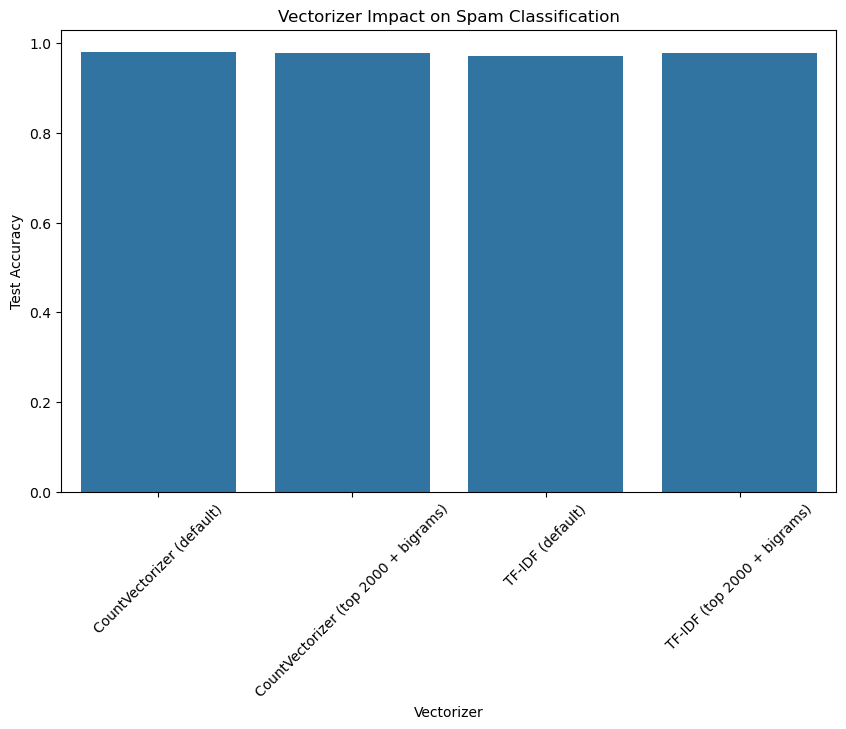

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x='Vectorizer', y='Accuracy')
plt.xticks(rotation=45)
plt.title('Vectorizer Impact on Spam Classification')
plt.ylabel('Test Accuracy')
plt.show()
